# Model Validation Specialist home assignment

## Task 2

### Introduction

The aim of this report is to predict loan approval for new applicants based on the data of past applicants.

### Data loading and preprocessing

I have saved your provided Excel tables as csv files accordingly.

In [10]:
import pandas as pd

applications_data = pd.read_csv('applications_decided_on.csv')
new_applications = pd.read_csv('new_applications.csv')

Changing the categorical variables into binary format.

In [11]:
applications_data['Obligations'] = applications_data['Obligations'].map({'YES': 1, 'NO': 0})
applications_data['Got_Approval'] = applications_data['Got_Approval'].map({'YES': 1, 'NO': 0})

new_applications['Obligations'] = new_applications['Obligations'].map({'YES': 1, 'NO': 0})

Normalizing the data. I'm using standardization method, which scales the features based on standard deviation and makes the mean of each feature 0.
Normalization's aim is to bring every feature to a similar scale so that no particular feature dominates others, which can bias the alorithm.

In [12]:
from sklearn.preprocessing import StandardScaler

features = ['Monthly_Income', 'Years_Worked', 'Obligations']

scaler = StandardScaler()
applications_data[features] = scaler.fit_transform(applications_data[features])
new_applications[features] = scaler.transform(new_applications[features])

### Model Selection and training

I am choosing logistics regression model because it is a go-to method for binary (YES/NO) classification problems. Also it provides probabilities with the binary output, which is useful to for ranking the applicants. This model is relatively simple and efficient compared to other models. If it performs satisfactorily, there might not be a need for more complex models.

Other models for binary classifications are decision trees, random forest, gradient boosted trees, neural networks etc.


Splitting the application data into training and testing sets. I'm using the standard 30% testing and 70% training ratio.

In [14]:
from sklearn.model_selection import train_test_split

X = applications_data[features]
y = applications_data['Got_Approval']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Using a logistic regression model for training.

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Model validation and performance

Validating the model using the testing dataset.

In [16]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_score}")

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       318
           1       0.91      0.93      0.92       282

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

ROC-AUC Score: 0.9270038806369598


The precision and recall for loans "not approved" are 94% and 92% respectively. For "approved" they are 91% and 93%.
The F1-score is above 0.9, which is excellent. The overall accuracy of the model is 93%, meaning 93% of the predictions were correct.
The ROC-AUC score is above 0.9 which is also considered excellent.

For the last thing, I would check for overfitting by comparing the model's performance on both the training set and the test set. If the model performs significantly better on the training set compared to the test set, it may be overfitting.

In [24]:
y_train_pred = model.predict(X_train)
print("Performance on Training Data:")
print(classification_report(y_train, y_train_pred))
roc_train_score = roc_auc_score(y_train, y_train_pred)
print(f"ROC-AUC Score for Training Data: {roc_train_score}")

Performance on Training Data:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       767
           1       0.92      0.90      0.91       633

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400

ROC-AUC Score for Training Data: 0.9155487723244169


Comparing these results with the testing data, we can tell that the performance is roughly similar, indicating no overfitting is taking place.

### Prediction for new applicants

Predicting approval chances for new appliants dataset.

In [17]:
new_applications['Approval_Probability'] = model.predict_proba(new_applications[features])[:, 1]

Selecting top 500 applicants.

In [29]:
top_500_applicants = new_applications.nlargest(500, 'Approval_Probability')
top_500_applicants[['Client_No', 'Approval_Probability']].to_csv('top_500_applicants.csv', index=False)

In [30]:
top_500_applicants[['Client_No', 'Approval_Probability']]

,Client_No,Approval_Probability
413,1228,1.000000
713,2156,1.000000
729,2219,1.000000
108,327,1.000000
16,59,0.999999
...,...,...
929,2787,0.470279
280,816,0.470218
343,992,0.466212
23,83,0.461903


Probability that Client no 200 will fall under the category "Approved".

In [20]:
client_200_prob = new_applications[new_applications['Client_No'] == 200]['Approval_Probability'].values[0]
print(f"Probability that client number 200 will get approval: {client_200_prob}")

Probability that client number 200 will get approval: 0.06012812688303123


The most important variable for approval. The importance of a feature can be derived from the coefficients of the model. The magnitude (regardless whether it's positive or negative) suggests greater importance.

In [21]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

          Feature  Importance
0  Monthly_Income    5.619488
1    Years_Worked    0.739109
2     Obligations   -1.268459


### Visualisations

Feature importance from logistic regression. This bar plot will showcase the importance of each feature in determining loan approval. The bar magnitude indicates importance, the direction suggests the correlation with the approval.

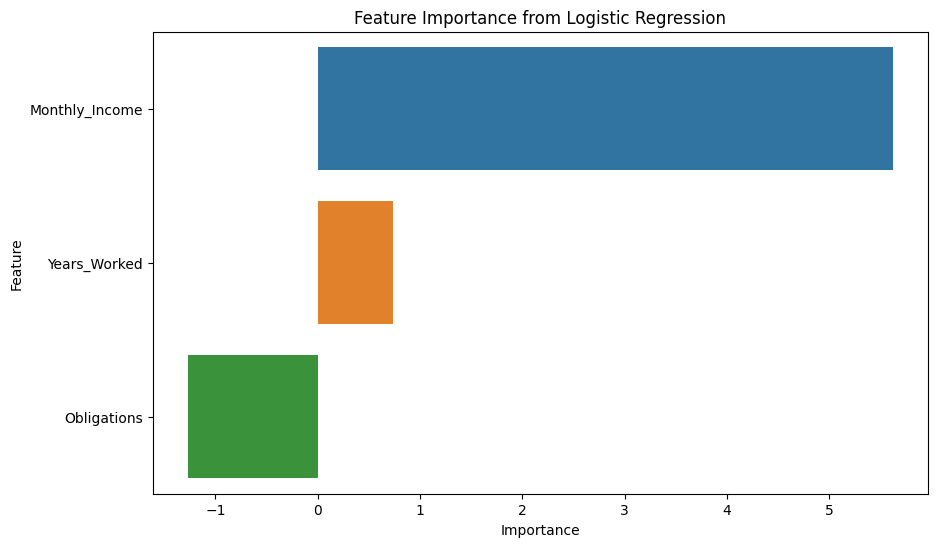

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

coefficients = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': coefficients
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Logistic Regression')
plt.show()

ROC Curve. This illustrates how well my model disgtinguishes between "approved" and "not approved". AUC of 1 indicates a perfect classifier. AUC of 0.5 is equal to random guessing. THE AUC for my model is 0.99.

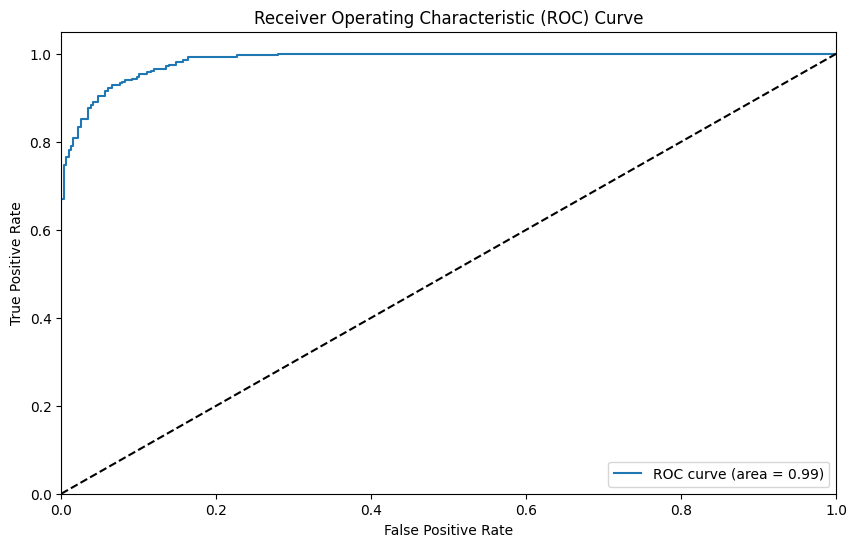

In [23]:
from sklearn.metrics import roc_curve, auc

# Compute the probabilities and the ROC curve values
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()